In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
from datetime import datetime, timedelta
from scipy.stats import poisson, truncnorm
from random import randrange
import pandas as pd
from scipy.stats import halfcauchy 

warnings.filterwarnings("ignore",category=UserWarning)

In [3]:
class PoissonGenerator:
    """
    Generate transactions timestamps list. Current version works with milliseconds.
    """
    def __init__(self, cycle_size: int, mean_occurencies: float):
        """
        Create a Poisson generator
        
        Keyword_arguments:
        cycle_size (int) -- reviewable cycle size in milliseconds
        mean_occurencies (float) -- mean amount of transactions
            happening in given cycle size
        """
        self.cycle_size = cycle_size
        self.mean_occurencies = mean_occurencies
        self.cumulative_probabilities = 0
        
        
    def __generate_poisson_outcome__(self) -> int:
        """
        Generate how many transactions will happen, considering cycle size 
        and mean transaction amount
        """
        return np.random.poisson(self.mean_occurencies, 1)[0]
    
    
    def generate_transactions(self, current_timestamp: datetime) -> list:
        """
        Generate array of transactions timestamps, considering Poisson distribution and
        random distribution of timestamps in given cycle size
        
        Keyword_arguments:
        current_timestamp (datetime) -- reviewable cycle starting point
        """
        transactions_timestamps = []
        current_transaction_count = self.__generate_poisson_outcome__()
        for i in range(current_transaction_count):
            transactions_timestamps.append(current_timestamp + timedelta(milliseconds=randrange(self.cycle_size)))
        return transactions_timestamps



class NormalGenerator:
    """
    Generate transaction values conform normal distribution
    """
    def __init__(self, mu: float, sigma: float, lower_bound: float, upper_bound: float):
        """
        Create a normal distribution generator
        
        Keyword_arguments:
        mu (float) -- mean transaction price
        sigma (float) -- standard deviation of transaction price
        lower_bound (float) -- distribution lower bound
        upper_bound (float) -- distribution upper bound
        """
        if lower_bound > upper_bound:
            raise ValueError("creation: lower bound value can't be bigger than upper bound")
        elif mu < lower_bound:
            raise ValueError("creation: mean value (mu) can't be lower than lower bound")
        elif mu > upper_bound:
            raise ValueError("creation: mean value (mu) can't be bigger than upper bound")
        
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.mu = mu
        self.sigma = sigma
      
    
    def reset_params(self, mu: float, sigma: float, lower_bound: float, upper_bound: float):
        """
        Change mean and standard deviation parameters of existing generator
        
        Keyword_arguments:
        mu (float) -- mean transaction price
        sigma (float) -- standard deviation of transaction price
        lower_bound (float) -- distribution lower bound
        upper_bound (float) -- distribution upper bound
        """
        if lower_bound > upper_bound:
            raise ValueError("bounds editing: lower bound value can't be bigger than upper bound")
        elif mu < lower_bound:
            raise ValueError("bounds editing: mean value (mu) can't be lower than lower bound")
        elif mu > upper_bound:
            raise ValueError("bounds editing: mean value (mu) can't be bigger than upper bound")
        
        self.mu = mu
        self.sigma = sigma
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        
    
    def generate_transactions(self, transactions_count: int) -> list:
        """
        Generate transaction prices list considering mu and sigma
        
        Keyword_arguments:
        transactions_count (int) -- required transactions count
        """
        return truncnorm.rvs(
            (self.lower_bound - self.mu)/self.sigma, 
            (self.upper_bound - self.mu)/self.sigma, 
            loc=self.mu, scale=self.sigma, size=transactions_count
        )



class CauchyGenerator:
    """
    Generate transaction values conform Cauchy distribution
    """
    def __init__(self, loc: float, scale: float, limit: int):
        """
        Create Cauchy generator with initial parameters
        
        Keyword_arguments:
        loc (float) -- locational parameter that defines where distribution
            will be centered
        scale (float) -- how far will tales (distribution) go
        """
        self.loc = loc
        self.scale = scale
        self.limit = limit
      
    
    def reset_params(self, loc: float, scale: float, limit: int):
        """
        Change mean and standard deviation parameters of existing generator
        
        Keyword_arguments:
        loc (float) -- locational parameter that defines where distribution
            will be centered
        scale (float) -- how far will tales (distribution) go
        """
        self.loc = loc
        self.scale = scale
        self.limit = limit
        
    
    def generate_transactions(self, transactions_count: int) -> list:
        """
        Generate transaction prices list considering mu and sigma
        
        Keyword_arguments:
        transactions_count (int) -- required transactions count
        """
        value = halfcauchy.rvs(size=transactions_count, loc=self.loc, scale=self.scale)
        return value / ((value // self.limit) + 1)



class ParetoGenerator:
    """
    Generate transaction values conform Pareto distribution
    """
    def __init__(self, shape: float):
        """
        Create Cauchy generator with initial parameters
        
        Keyword_arguments:
        shape (float) -- shape of distribution
        """
        self.shape = shape
      
    
    def reset_params(self, shape: float):
        """
        Change distribution shape

        Keyword arguments:
        shape (float) -- distribution shape
        """
        self.shape = shape
        
    
    def generate_transactions(self, transactions_count: int) -> list:
        """
        Generate transaction prices list considering params
        
        Keyword_arguments:
        transactions_count (int) -- required transactions count
        """
        return np.random.pareto(self.shape, size=transactions_count)



class Transaction:
    """
    Class with information regarding swapping transaction
    """
    def __init__(self, timestamp: datetime, 
                token_in_amount: float, token_in: str, 
                token_out: str, 
                slope: float=0.05):
        self.datetime_timestamp = timestamp
        self.token_in = token_in
        self.token_in_amount = token_in_amount
        self.token_out = token_out
        self.token_out_amount = None
        self.slope = slope


    def set_token_out_amount(self, token_out_amount: float):
        self.token_out_amount = token_out_amount
        
    
    def to_string(self) -> str:
        return str(
            'Transaction {datetime timestamp = ' + str(self.datetime_timestamp) + 
            ', token in amount = "' + str(self.token_in_amount) + 
            '", token in name = ' + str(self.token_in) + 
            ', token out amount = ' + str(self.token_out_amount) + 
            ', token out name = ' + str(self.token_out) + 
            ', slope = ' + str(self.slope) + '}'
        )

    
    def to_record(self) -> np.array:
        """
        Transform transaction data into numpy array of data
        """
        return np.array([
            self.datetime_timestamp,
            self.token_in,
            self.token_in_amount,
            self.token_out,
            self.token_out_amount,
            self.slope
        ])



class MonteCarloTransactionSimulator:
    """
    Monte Carlo transactions generator, that generates transactions frequency using Poisson 
    distribution and transaction values using normal distribution (time metrics - milliseconds)
    """
    def __init__(self, frequency_generator: PoissonGenerator, token_in_generator, first_currency: str, second_currency: str):
        """
        Create a Monte-Carlo transaction simulator
        
        Keyword_arguments:
        frequency_generator (PoissonGenerator) -- Poisson transaction distribution generator
        token_in_generator -- transaction distribution generator (accepts normal, Cauchy and 
            Pareto)
        first_currency -- name of the first token in transaction
        second_currency -- name of the second token in transaction
        """
        self.frequency_generator = frequency_generator
        self.token_in_generator = token_in_generator
        self.first_currency = first_currency
        self.second_currency = second_currency
        self.transaction_history = []
        
    
    def get_token_in_generator(self):
        """
        Get transactions distribution generator (can be normal, Cauchy and Pareto)
        """
        return self.token_in_generator
        
        
    def clear_transaction_history(self):
        """
        Clear all records from transaction history
        """
        self.transaction_history.clear()
    
    
    def generate_transactions(self, current_timestamp: datetime):
        """
        Generates transactions list with timestamps and token_in values. All transactions are recorded
        to the 'transaction_history' variable.
        
        Keyword arguments:
        current_timestamp (datetime) -- initial datetime point from where cycle will be reviewed
        current_amm_coef (float) -- current AMM market coefficient that defines price of out
            token relative to in token
        """
        # generate timestamps and token_in values
        timestamps = self.frequency_generator.generate_transactions(current_timestamp)
        timestamps.sort()
        token_in_values = self.token_in_generator.generate_transactions(len(timestamps))
        
        # form new transactions and record them into 'transaction history' variable
        for index in range(len(timestamps)):
            new_transaction = Transaction(
                timestamp=timestamps[index], 
                token_in_amount=token_in_values[index], 
                token_in=self.first_currency,
                token_out=self.second_currency
            )
            self.transaction_history.append(new_transaction)


    def get_history(self) -> list:
        """
        Get transaction history
        """
        return self.transaction_history
            
            
    def transaction_history_to_csv(self, filename: str):
        """
        Write transaction history to specified .csv file
        
        Keyword arguments:
        filename (str) -- name of .csv file where to write data
        """
        # vectorize all transactions into numpy matrix and then make dataframe out of it
        transactions_matrix = np.array([transaction.to_record() for transaction in self.transaction_history])
        transaction_history_df = pd.DataFrame(data=transactions_matrix, columns=[
            'datetime_timestamp', 'TokenIn', 'TokenInAmount', 'TokenOut', 'TokenOutAmount', 'Slope'
        ])

        # fix transformation of numerical features into string at numpy stage to numerical again
        transaction_history_df['TokenInAmount'] = pd.to_numeric(transaction_history_df['TokenInAmount'])
        transaction_history_df['TokenOutAmount'] = pd.to_numeric(transaction_history_df['TokenOutAmount'])
        
        # either append new records to the existing file, or create a new one from existing table
        try:
            with open(filename) as f:
                transaction_history_df.to_csv(filename, mode='a', header=False)
        except IOError:
            transaction_history_df.to_csv(filename)


    def get_dataframe(self) -> pd.DataFrame:
        # vectorize all transactions into numpy matrix and then make dataframe out of it
        transactions_matrix = np.array([transaction.to_record() for transaction in self.transaction_history])
        transaction_history_df = pd.DataFrame(data=transactions_matrix, columns=[
            'datetime_timestamp', 'TokenIn', 'TokenInAmount', 'TokenOut', 'TokenOutAmount', 'Slope'
        ])

        # fix transformation of numerical features into string at numpy stage to numerical again
        transaction_history_df['TokenInAmount'] = pd.to_numeric(transaction_history_df['TokenInAmount'])
        transaction_history_df['TokenOutAmount'] = pd.to_numeric(transaction_history_df['TokenOutAmount'])

        return transaction_history_df

In [4]:
class ParameterSearcher:
    def __init__(self, value_generator: CauchyGenerator, target_df: pd.DataFrame, token_symbol: str):
        """
        create new cauchy parameter searcher

        Keyword arguments:
        value_generator (CauchyGenerator) -- cauchy value generator
        target_df (pandas.DataFrame) -- pandas dataframe that has real-life data
        token_symbol (str) -- choose for which token is required to analyze distribution
        """
        self.value_generator = value_generator
        self.target_list = target_df[target_df.TokenSymbol == token_symbol].Value

    
    def search_parameters(self, initial_scale: float, step: float, final_scale: float, title: str, acc: int=100, x_size: int=10, y_size: int=10):
        """
        pick best scale parameter for cauchy distribution

        Keyword arguments:
        initial_scale (float) -- starting point to tune scale
        step (float) -- step value for incrementing scale for iteration
        final_scale (float) -- final scale point
        acc (int) -- how many cauchy generations are required to test each scale value, higher it is - more precise
            will be final result (default 100)
        x_size (int) -- plot x axis size
        y_size (int) -- plot y axis size
        """
        # get real life percentiles
        quartile = np.percentile(self.target_list, 25)
        median = np.percentile(self.target_list, 50)

        # set starting value for scale
        self.value_generator.scale = initial_scale

        # generate transactions for initial scales many times, calculate for each generation percentiles
        generated_table = [self.value_generator.generate_transactions(len(self.target_list)) for i in range(0, acc)]
        generated_quartiles = np.apply_along_axis(lambda row: np.percentile(row, 25), 0, generated_table)
        generated_medians = np.apply_along_axis(lambda row: np.percentile(row, 50), 0, generated_table)

        # find mean percentiles values
        generated_quartile = np.mean(generated_quartiles)
        generated_median = np.mean(generated_medians)

        # find error between real-life distribution and generated ones
        harmonic_mean_error = 2 * abs(quartile - generated_quartile) * abs(median - generated_median) / (
                                    abs(quartile - generated_quartile) + abs(median - generated_median))

        # form initial "best value", set table of scales with respective mean harmonic error, set lambda to pick best result
        best_match_tuple = (harmonic_mean_error, initial_scale)
        final_np_array = np.array([harmonic_mean_error, initial_scale])
        harmonic_mean_test = lambda cur_e, prev_e, cur_s, prev_s: (cur_e, cur_s) if cur_e < prev_e else (prev_e, prev_s)

        for current_scale in np.arange(initial_scale + step, final_scale, step):
            self.value_generator.scale = current_scale

            # find mean percentiles from many generations of cauchy
            generated_table = [self.value_generator.generate_transactions(len(self.target_list)) for i in range(0, acc)]
            generated_quartiles = np.apply_along_axis(lambda row: np.percentile(row, 25), 0, generated_table)
            generated_medians = np.apply_along_axis(lambda row: np.percentile(row, 50), 0, generated_table)
            generated_quartile = np.mean(generated_quartiles)
            generated_median = np.mean(generated_medians)

            # find best match conform harmonic mean and append current result to history of scales with errors
            harmonic_mean_error = 2 * abs(quartile - generated_quartile) * abs(median - generated_median) / (
                                        abs(quartile - generated_quartile) + abs(median - generated_median))
            final_np_array = np.vstack([final_np_array, [harmonic_mean_error, current_scale]])
            best_match_tuple = harmonic_mean_test(harmonic_mean_error, best_match_tuple[0], current_scale, best_match_tuple[1])

        # show best results
        print(best_match_tuple)

        # plot scales with respective errors
        plt.figure(figsize=(x_size, y_size))
        ax = sns.lineplot(x=final_np_array[:, 1], y=final_np_array[:, 0])
        ax.set_title(title)
        ax.set_xlabel("scale")
        ax.set_ylabel("harmonic error")
        plt.show()



class TransactionHistory:
    """
    Class that will separate transaction history by categories
    """
    def __init__(self):
        self.pool_address = None

        # basic dataframes references
        self.user_in_swap_df = None
        self.user_out_swap_df = None
        self.pool_investments_df = None
        self.pool_extractions_df = None
        self.anomalies_df = None

        # additional dataframes references with moving averages
        self.smaller_avg_in_swap_df = None
        self.bigger_avg_in_swap_df = None
        self.smaller_avg_out_swap_df = None
        self.bigger_avg_out_swap_df = None
        self.smaller_avg_investments_df = None
        self.bigger_avg_investmets_df = None
        self.smaller_avg_exractions_df = None
        self.bigger_avg_extractions_df = None
        self.smaller_avg_anomalies = None
        self.bigger_avg_anomalies = None


    def __contract_address_count__(self, s):
        return (s == self.pool_address).sum()


    def __set_mov_smaller_avg__(self, df: pd.DataFrame, smaller_avg: str) -> pd.DataFrame:
        """
        generate dataframe with smaller cycle of moving average

        Keyword arguments:
        df (pandas.DataFrame) -- table for which moving average should be found
        smaller_avg (str) -- string that defines cycle size to calculate
            moving average
        """
        df_time = df.copy()
        df_time.UnixTimestamp = pd.to_datetime(df_time.UnixTimestamp, unit='s')
        df_time.index = df_time.UnixTimestamp
        return df_time.resample(smaller_avg).mean()

    
    def __set_mov_bigger_avg__(self, df: pd.DataFrame, bigger_avg: str) -> pd.DataFrame:
        """
        generate dataframe with bigger cycle of moving average (resampling)

        Keyword arguments:
        df (pandas.DataFrame) -- table for which moving average should be found
        smaller_avg (str) -- string that defines cycle size to calculate
            moving average
        """
        df_time = df.copy()
        df_time.UnixTimestamp = pd.to_datetime(df_time.UnixTimestamp, unit='s')
        df_time.index = df_time.UnixTimestamp
        return df_time.rolling(bigger_avg).mean()
   
    
    def classify_history(self, transactions_df: pd.DataFrame):
        """
        Separate history in different dataframes conform transaction parameters
        ('swapping in/out', 'investments, extractions' and 'anomalies') that
        can be requested as current class object fields
        
        Keyword arguments:
        transactions_df (pandas.DataFrame) -- table of all transactions
        """
        # find address of the pool - most of the transactions will be related to pool
        self.pool_address = transactions_df['From'].mode()[0]
        
        # create matrix of transactions hashes and counters of in/out pool movements
        group_df = transactions_df.groupby('Txhash').agg({
            'From': self.__contract_address_count__,
            'To': self.__contract_address_count__
        })
        
        # form lists of swapping transactions, investments, extractions, anomalies
        swap_txhash_list = group_df[(group_df['From'] == 1) & (group_df['To'] == 1)].index.values
        investments_list = group_df[group_df['To'] == 2].index.values
        extractions_list = group_df[group_df['From'] == 2].index.values
        anomalies_list = group_df[(group_df['From'] > 2) | (group_df['To'] > 2)].index.values

        # record swapping in/out operations
        self.user_in_swap_df = transactions_df[(transactions_df['Txhash'].isin(swap_txhash_list)) & 
                                                (transactions_df['To'] == self.pool_address)]
        self.user_out_swap_df = transactions_df[(transactions_df['Txhash'].isin(swap_txhash_list)) & 
                                                (transactions_df['From'] == self.pool_address)]

        # record investments and extractions
        self.pool_investments_df = transactions_df[transactions_df['Txhash'].isin(investments_list)]
        self.pool_extractions_df = transactions_df[transactions_df['Txhash'].isin(extractions_list)]
        
        # record anomalies
        self.anomalies_df = transactions_df[transactions_df['Txhash'].isin(anomalies_list)]


    def form_moving_averages_for_token(self, smaller_average: str, bigger_average: str, target_token: str):
        """
        calculate tables with moving averages for given token and append those tables to object fields

        Keyword argument:
        smaller_average (str) -- string formatted smaller cycle to find moving average
        bigger_average (str) -- string formatted bigger cycle to find moving average
        target_token (str) -- token name for which moving average should be calculated
        """
        self.smaller_avg_in_swap_df = self.__set_mov_smaller_avg__(
            self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_in_swap_df = self.__set_mov_bigger_avg__(
            self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_out_swap_df = self.__set_mov_smaller_avg__(
            self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_out_swap_df = self.__set_mov_bigger_avg__(
            self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_investments_df = self.__set_mov_smaller_avg__(
            self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_investmets_df = self.__set_mov_bigger_avg__(
            self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_exractions_df = self.__set_mov_smaller_avg__(
            self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_extractions_df = self.__set_mov_bigger_avg__(
            self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_anomalies = self.__set_mov_smaller_avg__(
            self.anomalies_df[self.anomalies_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_anomalies = self.__set_mov_bigger_avg__(
            self.anomalies_df[self.anomalies_df['TokenSymbol'] == target_token], bigger_average)


    def lineplots_matrix(self, x_size: int, y_size: int, hspace:int, wspace: int, period_name: str):
        """
        make lineplots matrix

        Keyword arguments:
        x_size (int) -- matrix width
        y_size (int) -- matrix height
        hspace (int) -- inter-elements height
        wspace (int) -- inter-elements width
        period_name (str) -- name of analyzed time period
        """
        # get tokens present in dataframe
        tokens = self.user_in_swap_df['TokenSymbol'].unique()
        print(tokens)
        plt.figure(figsize=(x_size, y_size))

        # first currency graphs
        plt.subplot(5, 2, 1)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == tokens[0]], 
                    x='Datetime', y='Value', color='red').set_title(tokens[0] + ' swapping in (' + period_name + ')')
        plt.subplot(5, 2, 2)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == tokens[0]], 
                    x='Datetime', y='Value', color='green').set_title(tokens[0] + ' swapping out (' + period_name + ')')

        # second currency graphs
        plt.subplot(5, 2, 3)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == tokens[1]], 
                    x='Datetime', y='Value', color='red').set_title(tokens[1] + ' swapping in (' + period_name + ')')
        plt.subplot(5, 2, 4)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == tokens[1]], 
                    x='Datetime', y='Value', color='green').set_title(tokens[1] + ' swapping out (' + period_name + ')')


        plt.subplot(5, 2, 5)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == tokens[0]],
                    x='Datetime', y='Value', color='orange').set_title(tokens[0] + ' investments (' + period_name + ')')
        plt.subplot(5, 2, 6)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == tokens[1]],
                    x='Datetime', y='Value', color='magenta').set_title(tokens[1] + ' investments (' + period_name + ')')

        # extractions
        plt.subplot(5, 2, 7)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == tokens[0]],
                    x='Datetime', y='Value', color='orange').set_title(tokens[0] + ' extractions (' + period_name + ')')
        plt.subplot(5, 2, 8)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == tokens[1]],
                    x='Datetime', y='Value', color='magenta').set_title(tokens[1] + ' extractions (' + period_name + ')')

        # anomalies
        plt.subplot(5, 2, 9)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.anomalies_df[self.anomalies_df['TokenSymbol'] == tokens[0]],
                    x='Datetime', y='Value', color='orange').set_title(tokens[0] + ' anomalies (' + period_name + ')')
        plt.subplot(5, 2, 10)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.anomalies_df[self.anomalies_df['TokenSymbol'] == tokens[1]],
                    x='Datetime', y='Value', color='magenta').set_title(tokens[1] + ' anomalies (' + period_name + ')')

        plt.subplots_adjust(hspace=hspace, wspace=wspace)
        plt.show()


    def histplots_matrix(self, x_size: int, y_size: int, hspace:int, wspace: int, period_name: str, bins_v: int):
        """
        make histplots matrix

        Keyword arguments:
        x_size (int) -- matrix width
        y_size (int) -- matrix height
        hspace (int) -- inter-elements height
        wspace (int) -- inter-elements width
        period_name (str) -- name of analyzed time period
        """
        # get tokens present in dataframe
        tokens = self.user_in_swap_df['TokenSymbol'].unique()
        print(tokens)
        plt.figure(figsize=(x_size, y_size))

        # first currency graphs
        plt.subplot(5, 2, 1)
        plt.xticks(rotation=45)
        sns.histplot(data=self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == tokens[0]], 
                    x='Value', color='red', bins=bins_v).set_title(tokens[0] + ' swapping in (' + period_name + ')')
        plt.subplot(5, 2, 2)
        plt.xticks(rotation=45)
        sns.histplot(data=self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == tokens[0]], 
                    x='Value', color='green', bins=bins_v).set_title(tokens[0] + ' swapping out (' + period_name + ')')

        # second currency graphs
        plt.subplot(5, 2, 3)
        plt.xticks(rotation=45)
        sns.histplot(data=self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == tokens[1]], 
                    x='Value', color='red', bins=bins_v).set_title(tokens[1] + ' swapping in (' + period_name + ')')
        plt.subplot(5, 2, 4)
        plt.xticks(rotation=45)
        sns.histplot(data=self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == tokens[1]], 
                    x='Value', color='green', bins=bins_v).set_title(tokens[1] + ' swapping out (' + period_name + ')')


        plt.subplot(5, 2, 5)
        plt.xticks(rotation=45)
        sns.histplot(data=self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == tokens[0]],
                    x='Value', color='orange', bins=bins_v).set_title(tokens[0] + ' investments (' + period_name + ')')
        plt.subplot(5, 2, 6)
        plt.xticks(rotation=45)
        sns.histplot(data=self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == tokens[1]],
                    x='Value', color='magenta', bins=bins_v).set_title(tokens[1] + ' investments (' + period_name + ')')

        # extractions
        plt.subplot(5, 2, 7)
        plt.xticks(rotation=45)
        sns.histplot(data=self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == tokens[0]],
                    x='Value', color='orange', bins=bins_v).set_title(tokens[0] + ' extractions (' + period_name + ')')
        plt.subplot(5, 2, 8)
        plt.xticks(rotation=45)
        sns.histplot(data=self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == tokens[1]],
                    x='Value', color='magenta', bins=bins_v).set_title(tokens[1] + ' extractions (' + period_name + ')')

        # anomalies
        plt.subplot(5, 2, 9)
        plt.xticks(rotation=45)
        sns.histplot(data=self.anomalies_df[self.anomalies_df['TokenSymbol'] == tokens[0]],
                    x='Value', color='orange', bins=bins_v).set_title(tokens[0] + ' anomalies (' + period_name + ')')
        plt.subplot(5, 2, 10)
        plt.xticks(rotation=45)
        sns.histplot(data=self.anomalies_df[self.anomalies_df['TokenSymbol'] == tokens[1]],
                    x='Value', color='magenta', bins=bins_v).set_title(tokens[1] + ' anomalies (' + period_name + ')')

        plt.subplots_adjust(hspace=hspace, wspace=wspace)
        plt.show()


    def show_transactions_frequencies_per_minute(self):
        print("Swapping in transactions frequency: " + str(
            len(self.user_in_swap_df.Txhash.unique()) /
            ((self.user_in_swap_df.Datetime.max() - self.user_in_swap_df.Datetime.min()).total_seconds() 
            // 60)
        ))
        print("Swapping out transactions frequency: " + str(
            len(self.user_out_swap_df.Txhash.unique()) /
            ((self.user_out_swap_df.Datetime.max() - self.user_out_swap_df.Datetime.min()).total_seconds() 
            // 60)
        ))
        print("Investitions frequency: " + str(
            len(self.pool_investments_df.Txhash.unique()) /
            ((self.pool_investments_df.Datetime.max() - self.pool_investments_df.Datetime.min()).total_seconds() 
            // 60)
        ))
        print("Extractions frequency: " + str(
            len(self.pool_extractions_df.Txhash.unique()) /
            ((self.pool_extractions_df.Datetime.max() - self.pool_extractions_df.Datetime.min()).total_seconds() 
            // 60)
        ))


    def show_min_max_values_by_token(self):
        for token in self.user_in_swap_df['TokenSymbol'].unique():
            print("swapping in " + token + " min = " + str(th.user_in_swap_df[th.user_in_swap_df.TokenSymbol == token].Value.min()))
            print("swapping in " + token + " max = " + str(th.user_in_swap_df[th.user_in_swap_df.TokenSymbol == token].Value.max()))
            print("swapping out " + token + " min = " + str(th.user_out_swap_df[th.user_out_swap_df.TokenSymbol == token].Value.min()))
            print("swapping out " + token + " max = " + str(th.user_out_swap_df[th.user_out_swap_df.TokenSymbol == token].Value.max()))


    def lineplots_moving_averages_matrix_by_token(self, x_size: int, y_size: int, hspace: int, wspace: int,
                                first_token: str, second_token: str, 
                                period_name: str, smaller_avg: str, bigger_avg: str):
        """
        create lineplots matrix that shows moving averages for pool tokens

        Keyword arguments:
        x_size (int) -- width of lineplots matrix
        y_size (int) -- height of lineplots matrix
        hspace (int) -- height space between matrix subplots
        wspace (int) -- width space between matrix subplots
        first_token (str) -- name of left side token
        second_token (str) -- name of right side token
        period_name (str) -- string that defines time period of transactions
        smaller_avg (str) -- time cycle for finding small moving averages
        bigger_avg (str) -- time cycle for finding bigger moving averages
        """
        
        plt.figure(figsize=(x_size, y_size))

        # -----------------------------         first_token section     -----------------------------------
        self.form_moving_averages_for_token(smaller_avg, bigger_avg, first_token)

        plt.subplot(5, 2, 1)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_in_swap_df, x='UnixTimestamp', y='Value', color='red'
                    ).set_title(first_token + ' swap in moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 1)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_in_swap_df, x='UnixTimestamp', y='Value', color='green'
                    ).set_title(first_token + ' swap in moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 3)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_out_swap_df, x='UnixTimestamp', y='Value', color='red'
                    ).set_title(first_token + ' swap out moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 3)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_out_swap_df, x='UnixTimestamp', y='Value', color='green'
                    ).set_title(first_token + ' swap out moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 5)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_investments_df, x='UnixTimestamp', y='Value', color='red'
                    ).set_title(first_token + ' investments moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 5)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_investmets_df, x='UnixTimestamp', y='Value', color='green'
                    ).set_title(first_token + ' investments moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 7)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_exractions_df, x='UnixTimestamp', y='Value', color='red'
                    ).set_title(first_token + ' extractions moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 7)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_extractions_df, x='UnixTimestamp', y='Value', color='green'
                    ).set_title(first_token + ' extractions moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 9)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_anomalies, x='UnixTimestamp', y='Value', color='red'
                    ).set_title(first_token + ' anomalies moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 9)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_anomalies, x='UnixTimestamp', y='Value', color='green'
                    ).set_title(first_token + ' anomalies moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')

        # -----------------------------         second_token section     -------------------------------------
        self.form_moving_averages_for_token(smaller_avg, bigger_avg, second_token)

        plt.subplot(5, 2, 2)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_in_swap_df, x='UnixTimestamp', y='Value', color='orange'
                    ).set_title(second_token + ' swap in moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 2)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_in_swap_df, x='UnixTimestamp', y='Value', color='magenta'
                    ).set_title(second_token + ' swap in moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 4)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_out_swap_df, x='UnixTimestamp', y='Value', color='orange'
                    ).set_title(second_token + ' swap out moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 4)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_out_swap_df, x='UnixTimestamp', y='Value', color='magenta'
                    ).set_title(second_token + ' swap out moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 6)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_investments_df, x='UnixTimestamp', y='Value', color='orange'
                    ).set_title(second_token + ' investments moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 6)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_investmets_df, x='UnixTimestamp', y='Value', color='magenta'
                    ).set_title(second_token + ' investments moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 8)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_exractions_df, x='UnixTimestamp', y='Value', color='orange'
                    ).set_title(second_token + ' extractions moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 8)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_extractions_df, x='UnixTimestamp', y='Value', color='magenta'
                    ).set_title(second_token + ' extractions moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 10)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_anomalies, x='UnixTimestamp', y='Value', color='orange'
                    ).set_title(second_token + ' anomalies moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 10)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_anomalies, x='UnixTimestamp', y='Value', color='magenta'
                    ).set_title(second_token + ' anomalies moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')

        plt.subplots_adjust(hspace=hspace, wspace=wspace)
        plt.show()

In [5]:
def generator_week_df_and_plot(simulator: MonteCarloTransactionSimulator, time_window: int, x_size: int, y_size: int, x_bin_limit: int):
    current_iteration_timestamp = datetime.now()
    for index in range(time_window):
        simulator.generate_transactions(current_iteration_timestamp)
        current_iteration_timestamp += timedelta(milliseconds=simulator.frequency_generator.cycle_size)

    cauchy_sim_df = simulator.get_dataframe()

    plt.figure(figsize=(x_size, y_size))
    print("cauchy min token in = " + str(cauchy_sim_df.TokenInAmount.min()))
    print("cauchy max token in = " + str(cauchy_sim_df.TokenInAmount.max()))
    sns.histplot(data=cauchy_sim_df, x="TokenInAmount", bins=50, binrange=[0, x_bin_limit])
    plt.show()

In [13]:
# read transaction history
eth_usdc_df = pd.read_csv(os.getcwd() + "\stress_test_sim\pools_history\high_ETH-USDC_01-01_31-10.csv", index_col=False)

# make sure that Value will be interpreted as floating point number, remove possible 0 value elements
eth_usdc_df.Value = eth_usdc_df.Value.str.replace(",", "")
eth_usdc_df.Value = eth_usdc_df.Value.astype("float")
eth_usdc_df = eth_usdc_df[eth_usdc_df.Value > 0]

# make sure that datetime parameter is interpreted as date
eth_usdc_df['Datetime'] = pd.to_datetime(eth_usdc_df['UnixTimestamp'], unit='s')

# form transaction history separated by categories
th = TransactionHistory()
th.classify_history(eth_usdc_df)

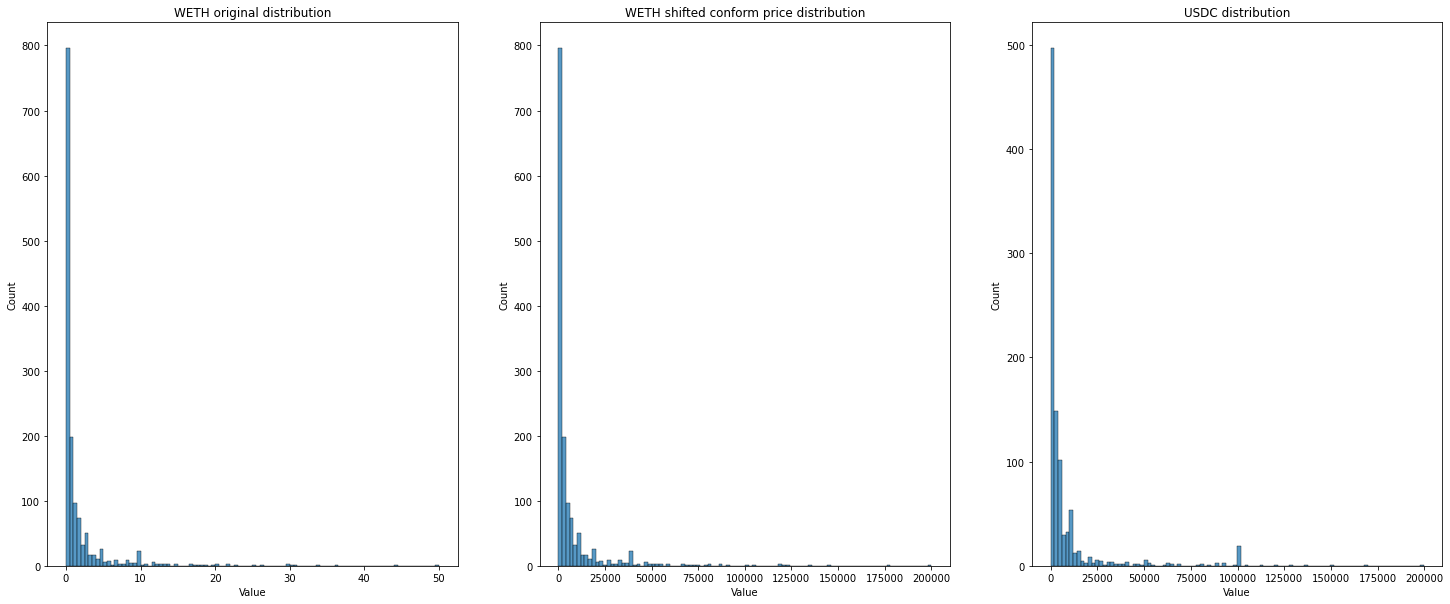

In [25]:
eth_swap_in_history = th.user_in_swap_df[th.user_in_swap_df.TokenSymbol == 'WETH'].Value
usdc_swap_in_history = th.user_in_swap_df[th.user_in_swap_df.TokenSymbol == 'USDC'].Value


plt.figure(figsize=(25, 10))
plt.subplot(1, 3, 1)
sns.histplot(x=eth_swap_in_history, bins=100).set_title('WETH original distribution')

eth_swap_in_history *= 4000

plt.subplot(1, 3, 2)
sns.histplot(x=eth_swap_in_history, bins=100).set_title('WETH shifted conform price distribution')

plt.subplot(1, 3, 3)
sns.histplot(data=usdc_swap_in_history, bins=100).set_title('USDC distribution')
plt.show()

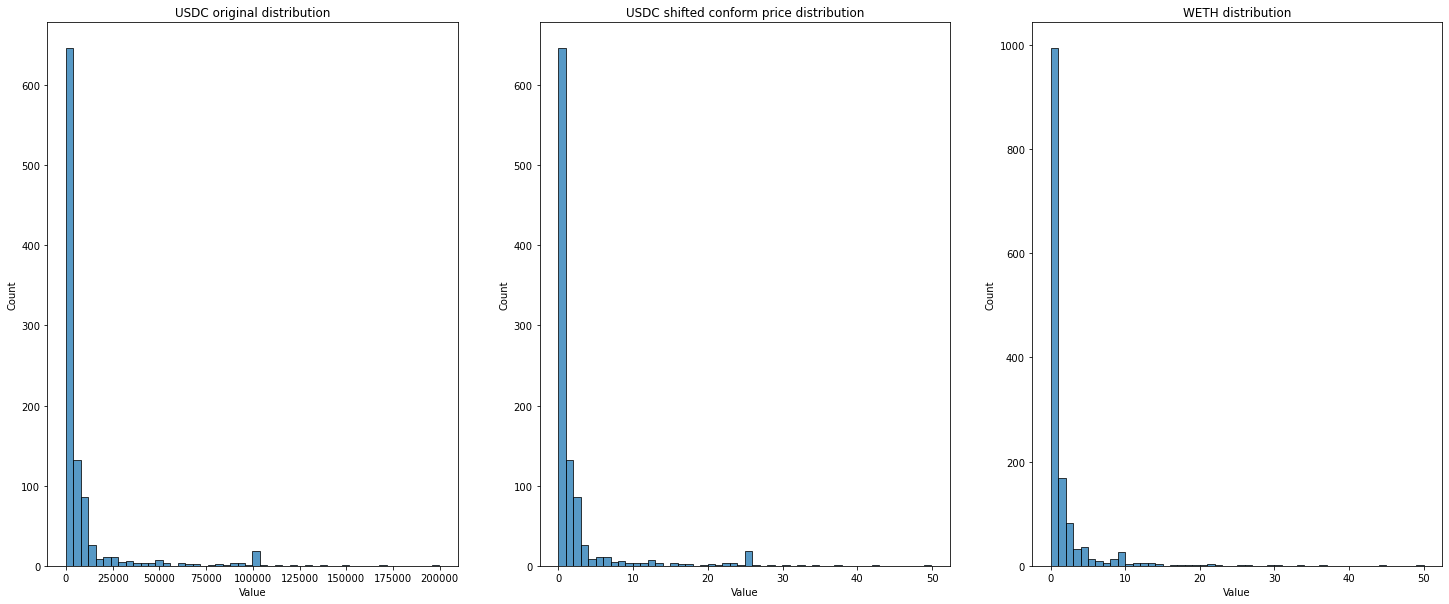

In [27]:
eth_swap_in_history = th.user_in_swap_df[th.user_in_swap_df.TokenSymbol == 'WETH'].Value
usdc_swap_in_history = th.user_in_swap_df[th.user_in_swap_df.TokenSymbol == 'USDC'].Value


plt.figure(figsize=(25, 10))
plt.subplot(1, 3, 1)
sns.histplot(x=usdc_swap_in_history, bins=50).set_title('USDC original distribution')

usdc_swap_in_history /= 4000

plt.subplot(1, 3, 2)
sns.histplot(x=usdc_swap_in_history, bins=50).set_title('USDC shifted conform price distribution')

plt.subplot(1, 3, 3)
sns.histplot(data=eth_swap_in_history, bins=50).set_title('WETH distribution')
plt.show()